In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Small(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 24, 2, 1], [4, 32, 2, 2], [4, 56, 3, 2], [6, 96, 2, 2]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 24
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
            if c == 32:
                layers.append(DynamicGraphAttention(in_channels, num_nodes=24, heads=4))
        self.body = nn.Sequential(*layers)

        self.head_conv = nn.Conv2d(96, 256, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(256, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.SiLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(128, num_classes))
    
    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'F:\metadata_Mel.csv' 
DATA_DIR = r'F:\MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'F:/checkpoints_small'
LOG_CSV_PATH = r'F:/training_log_small.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [13]:
model = PestLarvaNet_Small(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 0.59M tham số.


In [14]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy',
    'macro_f1', 'weighted_f1', 
    'micro_f1',  # Thay thế 'macro_precision', 'weighted_precision'
]
# --- KẾT THÚC THAY ĐỔI ---

with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'F:/checkpoints_small' và log tại 'F:/training_log_small.csv'


In [15]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels: continue # Bỏ qua các mẫu bị lỗi
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Áp dụng Mixup với xác suất 50%
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            # Chạy như bình thường nếu không dùng Mixup
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    
    # --- THAY ĐỔI Ở ĐÂY ---
    # Giữ nguyên F1-score với 2 phiên bản
    accuracy = accuracy_score(val_labels, val_preds)
    macro_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    micro_f1 = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    # Tính Precision và Recall phiên bản tổng thể (micro)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    # --- KẾT THÚC THAY ĐỔI ---
    
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # In kết quả ra màn hình
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Weighted F1: {weighted_f1:.4f}")
    # Thêm dòng in cho Precision và Recall tổng thể
    print(f"  Precision (Micro): {precision:.4f} | Recall (Micro): {recall:.4f}") 
    print(f"  Learning Rate: {current_lr:.6f}")

    # --- THAY ĐỔI Ở ĐÂY ---
    # Lưu vào file CSV
    log_data = [
        epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy,
        macro_f1, weighted_f1, 
        precision, # Thay thế các phiên bản macro/weighted
        recall     # Thay thế các phiên bản macro/weighted
    ]
    # --- KẾT THÚC THAY ĐỔI ---

    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(log_data)
        
    # Lưu Checkpoint mỗi epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # Lưu lại model tốt nhất (dựa trên weighted F1-score)
    if weighted_f1 > best_val_f1:
        best_val_f1 = weighted_f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (Weighted F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.3718 | Val Loss: 1.2007
  Accuracy: 0.5922 | Weighted F1: 0.5799
  Precision (Micro): 0.5922 | Recall (Micro): 0.5922
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.5799)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.1029 | Val Loss: 0.7661
  Accuracy: 0.7276 | Weighted F1: 0.7217
  Precision (Micro): 0.7276 | Recall (Micro): 0.7276
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.7217)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 1.0144 | Val Loss: 0.8092
  Accuracy: 0.7226 | Weighted F1: 0.7205
  Precision (Micro): 0.7226 | Recall (Micro): 0.7226
  Learning Rate: 0.000999


Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.9429 | Val Loss: 0.6825
  Accuracy: 0.7612 | Weighted F1: 0.7567
  Precision (Micro): 0.7612 | Recall (Micro): 0.7612
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.7567)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8879 | Val Loss: 0.9152
  Accuracy: 0.7006 | Weighted F1: 0.7028
  Precision (Micro): 0.7006 | Recall (Micro): 0.7006
  Learning Rate: 0.000996


Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.8300 | Val Loss: 1.0387
  Accuracy: 0.6602 | Weighted F1: 0.6470
  Precision (Micro): 0.6602 | Recall (Micro): 0.6602
  Learning Rate: 0.000994


Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7804 | Val Loss: 0.5543
  Accuracy: 0.8057 | Weighted F1: 0.8010
  Precision (Micro): 0.8057 | Recall (Micro): 0.8057
  Learning Rate: 0.000991
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.8010)



Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.7242 | Val Loss: 0.5010
  Accuracy: 0.8271 | Weighted F1: 0.8258
  Precision (Micro): 0.8271 | Recall (Micro): 0.8271
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.8258)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.7071 | Val Loss: 0.4092
  Accuracy: 0.8564 | Weighted F1: 0.8552
  Precision (Micro): 0.8564 | Recall (Micro): 0.8564
  Learning Rate: 0.000984
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.8552)



Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6733 | Val Loss: 0.4857
  Accuracy: 0.8382 | Weighted F1: 0.8379
  Precision (Micro): 0.8382 | Recall (Micro): 0.8382
  Learning Rate: 0.000980


Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6402 | Val Loss: 0.7290
  Accuracy: 0.7603 | Weighted F1: 0.7513
  Precision (Micro): 0.7603 | Recall (Micro): 0.7603
  Learning Rate: 0.000976


Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.6216 | Val Loss: 0.4189
  Accuracy: 0.8552 | Weighted F1: 0.8535
  Precision (Micro): 0.8552 | Recall (Micro): 0.8552
  Learning Rate: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.6138 | Val Loss: 0.4500
  Accuracy: 0.8493 | Weighted F1: 0.8500
  Precision (Micro): 0.8493 | Recall (Micro): 0.8493
  Learning Rate: 0.000965


Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5806 | Val Loss: 0.3497
  Accuracy: 0.8813 | Weighted F1: 0.8806
  Precision (Micro): 0.8813 | Recall (Micro): 0.8813
  Learning Rate: 0.000959
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.8806)



Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5716 | Val Loss: 0.4963
  Accuracy: 0.8357 | Weighted F1: 0.8366
  Precision (Micro): 0.8357 | Recall (Micro): 0.8357
  Learning Rate: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5555 | Val Loss: 0.3848
  Accuracy: 0.8688 | Weighted F1: 0.8680
  Precision (Micro): 0.8688 | Recall (Micro): 0.8688
  Learning Rate: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5365 | Val Loss: 0.4164
  Accuracy: 0.8581 | Weighted F1: 0.8579
  Precision (Micro): 0.8581 | Recall (Micro): 0.8581
  Learning Rate: 0.000938


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5300 | Val Loss: 0.3188
  Accuracy: 0.8919 | Weighted F1: 0.8905
  Precision (Micro): 0.8919 | Recall (Micro): 0.8919
  Learning Rate: 0.000930
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.8905)



Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5067 | Val Loss: 0.6042
  Accuracy: 0.8165 | Weighted F1: 0.8132
  Precision (Micro): 0.8165 | Recall (Micro): 0.8165
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5163 | Val Loss: 0.3793
  Accuracy: 0.8729 | Weighted F1: 0.8745
  Precision (Micro): 0.8729 | Recall (Micro): 0.8729
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.5042 | Val Loss: 0.3414
  Accuracy: 0.8847 | Weighted F1: 0.8830
  Precision (Micro): 0.8847 | Recall (Micro): 0.8847
  Learning Rate: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.5016 | Val Loss: 0.4315
  Accuracy: 0.8600 | Weighted F1: 0.8603
  Precision (Micro): 0.8600 | Recall (Micro): 0.8600
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4862 | Val Loss: 0.2823
  Accuracy: 0.9073 | Weighted F1: 0.9071
  Precision (Micro): 0.9073 | Recall (Micro): 0.9073
  Learning Rate: 0.000885
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9071)



Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4724 | Val Loss: 0.2911
  Accuracy: 0.9044 | Weighted F1: 0.9040
  Precision (Micro): 0.9044 | Recall (Micro): 0.9044
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4689 | Val Loss: 0.3324
  Accuracy: 0.8924 | Weighted F1: 0.8931
  Precision (Micro): 0.8924 | Recall (Micro): 0.8924
  Learning Rate: 0.000864


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4566 | Val Loss: 0.2870
  Accuracy: 0.9097 | Weighted F1: 0.9088
  Precision (Micro): 0.9097 | Recall (Micro): 0.9097
  Learning Rate: 0.000854
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9088)



Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4544 | Val Loss: 0.3712
  Accuracy: 0.8863 | Weighted F1: 0.8838
  Precision (Micro): 0.8863 | Recall (Micro): 0.8863
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4486 | Val Loss: 0.2927
  Accuracy: 0.9068 | Weighted F1: 0.9073
  Precision (Micro): 0.9068 | Recall (Micro): 0.9068
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4555 | Val Loss: 0.3540
  Accuracy: 0.8901 | Weighted F1: 0.8887
  Precision (Micro): 0.8901 | Recall (Micro): 0.8901
  Learning Rate: 0.000819


Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4358 | Val Loss: 0.4128
  Accuracy: 0.8727 | Weighted F1: 0.8716
  Precision (Micro): 0.8727 | Recall (Micro): 0.8727
  Learning Rate: 0.000806


Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4335 | Val Loss: 0.2949
  Accuracy: 0.9111 | Weighted F1: 0.9108
  Precision (Micro): 0.9111 | Recall (Micro): 0.9111
  Learning Rate: 0.000794
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9108)



Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4334 | Val Loss: 0.3471
  Accuracy: 0.8958 | Weighted F1: 0.8943
  Precision (Micro): 0.8958 | Recall (Micro): 0.8958
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.4157 | Val Loss: 0.2997
  Accuracy: 0.9070 | Weighted F1: 0.9066
  Precision (Micro): 0.9070 | Recall (Micro): 0.9070
  Learning Rate: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.4142 | Val Loss: 0.3623
  Accuracy: 0.8908 | Weighted F1: 0.8909
  Precision (Micro): 0.8908 | Recall (Micro): 0.8908
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.4104 | Val Loss: 0.3452
  Accuracy: 0.8979 | Weighted F1: 0.8984
  Precision (Micro): 0.8979 | Recall (Micro): 0.8979
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3917 | Val Loss: 0.3064
  Accuracy: 0.9050 | Weighted F1: 0.9058
  Precision (Micro): 0.9050 | Recall (Micro): 0.9050
  Learning Rate: 0.000727


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.4014 | Val Loss: 0.3722
  Accuracy: 0.8982 | Weighted F1: 0.8971
  Precision (Micro): 0.8982 | Recall (Micro): 0.8982
  Learning Rate: 0.000713


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3877 | Val Loss: 0.3382
  Accuracy: 0.9085 | Weighted F1: 0.9083
  Precision (Micro): 0.9085 | Recall (Micro): 0.9085
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3840 | Val Loss: 0.3420
  Accuracy: 0.9013 | Weighted F1: 0.9017
  Precision (Micro): 0.9013 | Recall (Micro): 0.9013
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3794 | Val Loss: 0.3532
  Accuracy: 0.9027 | Weighted F1: 0.9017
  Precision (Micro): 0.9027 | Recall (Micro): 0.9027
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3774 | Val Loss: 0.3324
  Accuracy: 0.9102 | Weighted F1: 0.9100
  Precision (Micro): 0.9102 | Recall (Micro): 0.9102
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3770 | Val Loss: 0.3342
  Accuracy: 0.9043 | Weighted F1: 0.9027
  Precision (Micro): 0.9043 | Recall (Micro): 0.9043
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3806 | Val Loss: 0.3069
  Accuracy: 0.9136 | Weighted F1: 0.9131
  Precision (Micro): 0.9136 | Recall (Micro): 0.9136
  Learning Rate: 0.000624
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9131)



Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3643 | Val Loss: 0.3449
  Accuracy: 0.9051 | Weighted F1: 0.9052
  Precision (Micro): 0.9051 | Recall (Micro): 0.9051
  Learning Rate: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3686 | Val Loss: 0.3111
  Accuracy: 0.9167 | Weighted F1: 0.9164
  Precision (Micro): 0.9167 | Recall (Micro): 0.9167
  Learning Rate: 0.000594
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9164)



Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3686 | Val Loss: 0.4574
  Accuracy: 0.8675 | Weighted F1: 0.8680
  Precision (Micro): 0.8675 | Recall (Micro): 0.8675
  Learning Rate: 0.000578


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3632 | Val Loss: 0.3210
  Accuracy: 0.9147 | Weighted F1: 0.9142
  Precision (Micro): 0.9147 | Recall (Micro): 0.9147
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3599 | Val Loss: 0.4573
  Accuracy: 0.8733 | Weighted F1: 0.8711
  Precision (Micro): 0.8733 | Recall (Micro): 0.8733
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3547 | Val Loss: 0.3506
  Accuracy: 0.9066 | Weighted F1: 0.9061
  Precision (Micro): 0.9066 | Recall (Micro): 0.9066
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3541 | Val Loss: 0.3425
  Accuracy: 0.9131 | Weighted F1: 0.9125
  Precision (Micro): 0.9131 | Recall (Micro): 0.9131
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3580 | Val Loss: 0.3550
  Accuracy: 0.9088 | Weighted F1: 0.9082
  Precision (Micro): 0.9088 | Recall (Micro): 0.9088
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3442 | Val Loss: 0.3476
  Accuracy: 0.9111 | Weighted F1: 0.9113
  Precision (Micro): 0.9111 | Recall (Micro): 0.9111
  Learning Rate: 0.000484


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3525 | Val Loss: 0.3435
  Accuracy: 0.9130 | Weighted F1: 0.9131
  Precision (Micro): 0.9130 | Recall (Micro): 0.9130
  Learning Rate: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3377 | Val Loss: 0.3600
  Accuracy: 0.9136 | Weighted F1: 0.9134
  Precision (Micro): 0.9136 | Recall (Micro): 0.9136
  Learning Rate: 0.000453


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3364 | Val Loss: 0.3383
  Accuracy: 0.9158 | Weighted F1: 0.9157
  Precision (Micro): 0.9158 | Recall (Micro): 0.9158
  Learning Rate: 0.000437


Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3390 | Val Loss: 0.3397
  Accuracy: 0.9135 | Weighted F1: 0.9131
  Precision (Micro): 0.9135 | Recall (Micro): 0.9135
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3317 | Val Loss: 0.3903
  Accuracy: 0.9103 | Weighted F1: 0.9099
  Precision (Micro): 0.9103 | Recall (Micro): 0.9103
  Learning Rate: 0.000406


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3410 | Val Loss: 0.3458
  Accuracy: 0.9172 | Weighted F1: 0.9168
  Precision (Micro): 0.9172 | Recall (Micro): 0.9172
  Learning Rate: 0.000391
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9168)



Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3548 | Val Loss: 0.3447
  Accuracy: 0.9151 | Weighted F1: 0.9149
  Precision (Micro): 0.9151 | Recall (Micro): 0.9151
  Learning Rate: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3377 | Val Loss: 0.3983
  Accuracy: 0.9049 | Weighted F1: 0.9054
  Precision (Micro): 0.9049 | Recall (Micro): 0.9049
  Learning Rate: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.3240 | Val Loss: 0.3637
  Accuracy: 0.9056 | Weighted F1: 0.9059
  Precision (Micro): 0.9056 | Recall (Micro): 0.9056
  Learning Rate: 0.000345


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3251 | Val Loss: 0.3694
  Accuracy: 0.9183 | Weighted F1: 0.9181
  Precision (Micro): 0.9183 | Recall (Micro): 0.9183
  Learning Rate: 0.000331
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9181)



Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3257 | Val Loss: 0.3665
  Accuracy: 0.9166 | Weighted F1: 0.9161
  Precision (Micro): 0.9166 | Recall (Micro): 0.9166
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.3267 | Val Loss: 0.4279
  Accuracy: 0.8900 | Weighted F1: 0.8908
  Precision (Micro): 0.8900 | Recall (Micro): 0.8900
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3053 | Val Loss: 0.3531
  Accuracy: 0.9128 | Weighted F1: 0.9123
  Precision (Micro): 0.9128 | Recall (Micro): 0.9128
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.3270 | Val Loss: 0.3698
  Accuracy: 0.9161 | Weighted F1: 0.9160
  Precision (Micro): 0.9161 | Recall (Micro): 0.9161
  Learning Rate: 0.000273


Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3223 | Val Loss: 0.3686
  Accuracy: 0.9170 | Weighted F1: 0.9164
  Precision (Micro): 0.9170 | Recall (Micro): 0.9170
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.3221 | Val Loss: 0.3552
  Accuracy: 0.9179 | Weighted F1: 0.9174
  Precision (Micro): 0.9179 | Recall (Micro): 0.9179
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.3096 | Val Loss: 0.3558
  Accuracy: 0.9179 | Weighted F1: 0.9177
  Precision (Micro): 0.9179 | Recall (Micro): 0.9179
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3110 | Val Loss: 0.3544
  Accuracy: 0.9170 | Weighted F1: 0.9168
  Precision (Micro): 0.9170 | Recall (Micro): 0.9170
  Learning Rate: 0.000219


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.3147 | Val Loss: 0.3642
  Accuracy: 0.9129 | Weighted F1: 0.9130
  Precision (Micro): 0.9129 | Recall (Micro): 0.9129
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.3021 | Val Loss: 0.3856
  Accuracy: 0.9181 | Weighted F1: 0.9179
  Precision (Micro): 0.9181 | Recall (Micro): 0.9181
  Learning Rate: 0.000194


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.3147 | Val Loss: 0.3660
  Accuracy: 0.9157 | Weighted F1: 0.9157
  Precision (Micro): 0.9157 | Recall (Micro): 0.9157
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3135 | Val Loss: 0.3635
  Accuracy: 0.9208 | Weighted F1: 0.9206
  Precision (Micro): 0.9208 | Recall (Micro): 0.9208
  Learning Rate: 0.000169
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9206)



Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.3231 | Val Loss: 0.3491
  Accuracy: 0.9145 | Weighted F1: 0.9145
  Precision (Micro): 0.9145 | Recall (Micro): 0.9145
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.3203 | Val Loss: 0.3551
  Accuracy: 0.9191 | Weighted F1: 0.9190
  Precision (Micro): 0.9191 | Recall (Micro): 0.9191
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.2996 | Val Loss: 0.3614
  Accuracy: 0.9219 | Weighted F1: 0.9216
  Precision (Micro): 0.9219 | Recall (Micro): 0.9219
  Learning Rate: 0.000136
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9216)



Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.3118 | Val Loss: 0.3605
  Accuracy: 0.9217 | Weighted F1: 0.9215
  Precision (Micro): 0.9217 | Recall (Micro): 0.9217
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2995 | Val Loss: 0.3742
  Accuracy: 0.9216 | Weighted F1: 0.9214
  Precision (Micro): 0.9216 | Recall (Micro): 0.9216
  Learning Rate: 0.000115


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.3121 | Val Loss: 0.3761
  Accuracy: 0.9167 | Weighted F1: 0.9163
  Precision (Micro): 0.9167 | Recall (Micro): 0.9167
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.3084 | Val Loss: 0.3498
  Accuracy: 0.9198 | Weighted F1: 0.9196
  Precision (Micro): 0.9198 | Recall (Micro): 0.9198
  Learning Rate: 0.000095


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2957 | Val Loss: 0.3743
  Accuracy: 0.9224 | Weighted F1: 0.9220
  Precision (Micro): 0.9224 | Recall (Micro): 0.9224
  Learning Rate: 0.000086
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9220)



Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.2985 | Val Loss: 0.3685
  Accuracy: 0.9204 | Weighted F1: 0.9201
  Precision (Micro): 0.9204 | Recall (Micro): 0.9204
  Learning Rate: 0.000078


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2961 | Val Loss: 0.3639
  Accuracy: 0.9214 | Weighted F1: 0.9212
  Precision (Micro): 0.9214 | Recall (Micro): 0.9214
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2921 | Val Loss: 0.3608
  Accuracy: 0.9202 | Weighted F1: 0.9200
  Precision (Micro): 0.9202 | Recall (Micro): 0.9202
  Learning Rate: 0.000062


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2939 | Val Loss: 0.3661
  Accuracy: 0.9190 | Weighted F1: 0.9190
  Precision (Micro): 0.9190 | Recall (Micro): 0.9190
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.3019 | Val Loss: 0.3757
  Accuracy: 0.9225 | Weighted F1: 0.9224
  Precision (Micro): 0.9225 | Recall (Micro): 0.9225
  Learning Rate: 0.000048
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9224)



Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.3070 | Val Loss: 0.3677
  Accuracy: 0.9238 | Weighted F1: 0.9236
  Precision (Micro): 0.9238 | Recall (Micro): 0.9238
  Learning Rate: 0.000041
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9236)



Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2920 | Val Loss: 0.3778
  Accuracy: 0.9232 | Weighted F1: 0.9229
  Precision (Micro): 0.9232 | Recall (Micro): 0.9232
  Learning Rate: 0.000035


Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2998 | Val Loss: 0.3611
  Accuracy: 0.9204 | Weighted F1: 0.9204
  Precision (Micro): 0.9204 | Recall (Micro): 0.9204
  Learning Rate: 0.000030


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.3021 | Val Loss: 0.3754
  Accuracy: 0.9221 | Weighted F1: 0.9218
  Precision (Micro): 0.9221 | Recall (Micro): 0.9221
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2999 | Val Loss: 0.3710
  Accuracy: 0.9224 | Weighted F1: 0.9224
  Precision (Micro): 0.9224 | Recall (Micro): 0.9224
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.3030 | Val Loss: 0.3777
  Accuracy: 0.9229 | Weighted F1: 0.9225
  Precision (Micro): 0.9229 | Recall (Micro): 0.9229
  Learning Rate: 0.000016


Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.3008 | Val Loss: 0.3650
  Accuracy: 0.9218 | Weighted F1: 0.9216
  Precision (Micro): 0.9218 | Recall (Micro): 0.9218
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2989 | Val Loss: 0.3705
  Accuracy: 0.9229 | Weighted F1: 0.9227
  Precision (Micro): 0.9229 | Recall (Micro): 0.9229
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2952 | Val Loss: 0.3668
  Accuracy: 0.9217 | Weighted F1: 0.9215
  Precision (Micro): 0.9217 | Recall (Micro): 0.9217
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2974 | Val Loss: 0.3586
  Accuracy: 0.9215 | Weighted F1: 0.9213
  Precision (Micro): 0.9215 | Recall (Micro): 0.9215
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2995 | Val Loss: 0.3787
  Accuracy: 0.9244 | Weighted F1: 0.9241
  Precision (Micro): 0.9244 | Recall (Micro): 0.9244
  Learning Rate: 0.000002
  => 🎉 New best model saved to 'F:/checkpoints_small\best_model.pth' (Weighted F1: 0.9241)



Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2887 | Val Loss: 0.3555
  Accuracy: 0.9212 | Weighted F1: 0.9211
  Precision (Micro): 0.9212 | Recall (Micro): 0.9212
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.3056 | Val Loss: 0.3676
  Accuracy: 0.9240 | Weighted F1: 0.9237
  Precision (Micro): 0.9240 | Recall (Micro): 0.9240
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


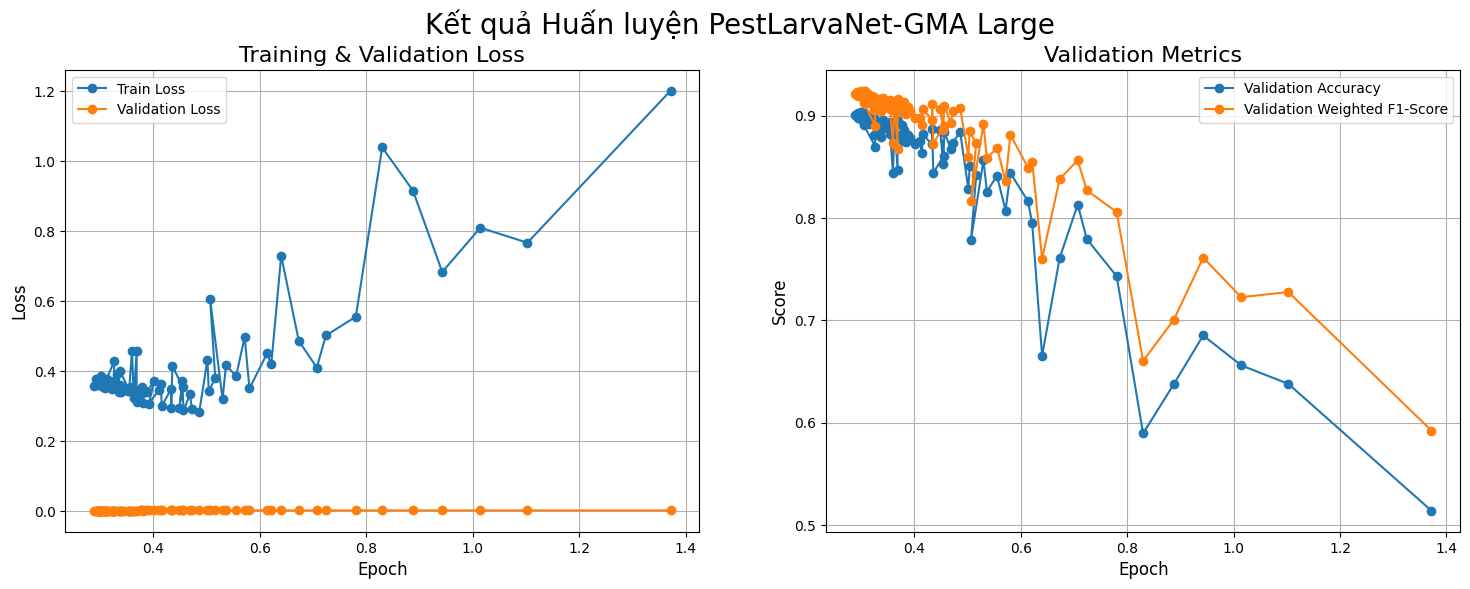


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


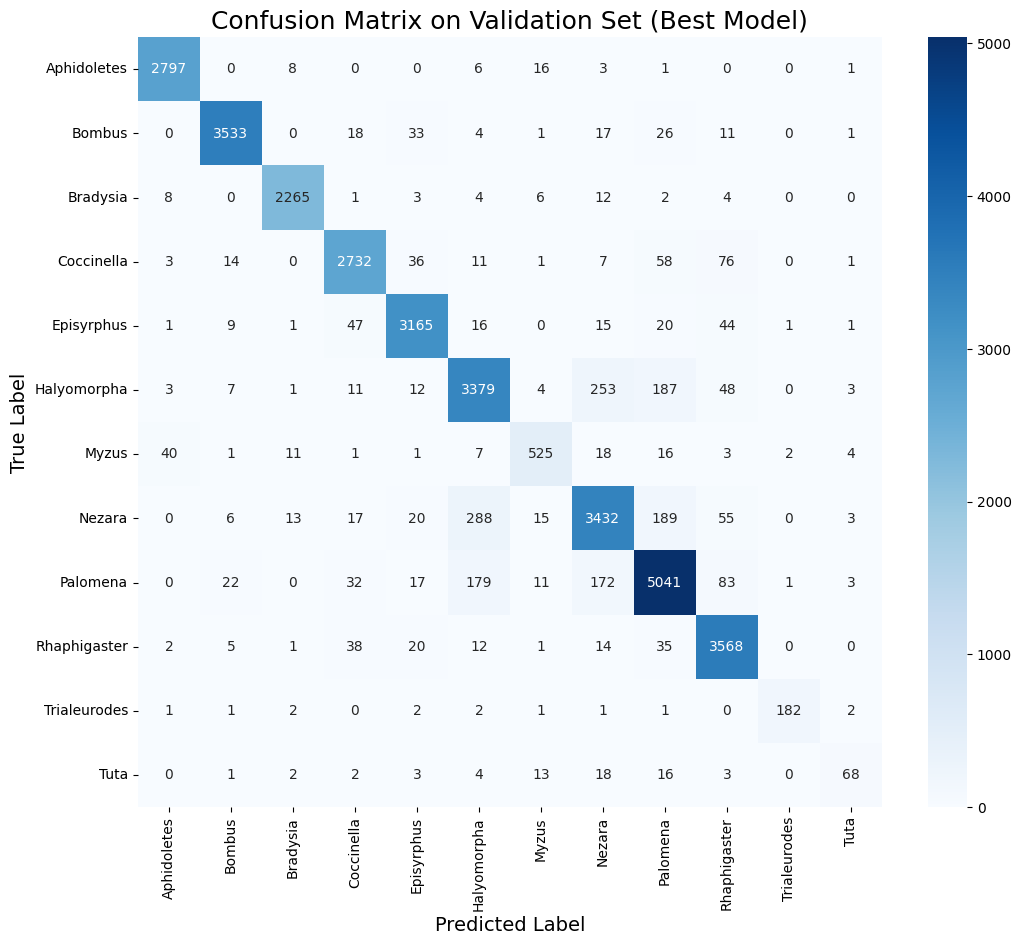

In [16]:
log_df = pd.read_csv(LOG_CSV_PATH)

# --- Vẽ biểu đồ Loss và Accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Validation Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['weighted_f1'], label='Validation Weighted F1-Score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-GMA Large', fontsize=20)
plt.show()

# --- Vẽ Ma trận nhầm lẫn (Confusion Matrix) ---
# Tải lại trọng số của model tốt nhất để đánh giá
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()